# Gradient Examinations with DCorr

In [1]:
import numpy as np
from pathlib import Path
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker

%matplotlib inline

import seaborn as sns

sns.set(color_codes=True, style="white", context="talk", font_scale=1)
PALETTE = sns.color_palette("Set1")

from sklearn.metrics import pairwise_distances
from hyppo.independence import Dcorr
from scipy.stats import multiscale_graphcorr
from hyppo.ksample._utils import k_sample_transform
from graspy.plot import heatmap

import sys

sys.path.append("../")
from src.tools.utils import get_files, get_latents

%load_ext autoreload
%autoreload 2
%load_ext nb_black

/home/rflperry/miniconda3/lib/python3.7/site-packages/sklearn/utils/deprecation.py:143: FutureWarning: The sklearn.mixture.gaussian_mixture module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.mixture. Anything that cannot be imported from sklearn.mixture is now part of the private API.
  warnings.warn(message, FutureWarning)


<IPython.core.display.Javascript object>

In [2]:
import seaborn as sns

sns.set(color_codes=True, style="white", context="poster", font_scale=2)
PALETTE = sns.color_palette("Set1")
sns.set_palette(PALETTE[3:])

<IPython.core.display.Javascript object>

In [20]:
base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-26-10:39_min_rank-ZG3/")
# base_dir = Path("/mnt/ssd3/ronan/data/gcca_05-17-18:27_max_rank-ZG2/")
groups, labels = get_latents(base_dir, flag="_gcca")

<IPython.core.display.Javascript object>

In [21]:
labels

[['e', 'restingstate'],
 ['e', 'openmonitoring'],
 ['e', 'compassion'],
 ['n', 'restingstate'],
 ['n', 'openmonitoring'],
 ['n', 'compassion']]

<IPython.core.display.Javascript object>

## Within experts
for each gradient, run dcorr on 3-sample expert states

In [22]:
ways = [[0], [1], [2]]
X, Y = k_sample_transform(groups[:3], ways=ways)
X = X[:, :, :3]

<IPython.core.display.Javascript object>

In [23]:
y = np.repeat(labels[:3], [len(g) for g in groups[:3]], axis=0)
y_labels = [f"{b}" for a, b in y]

<IPython.core.display.Javascript object>

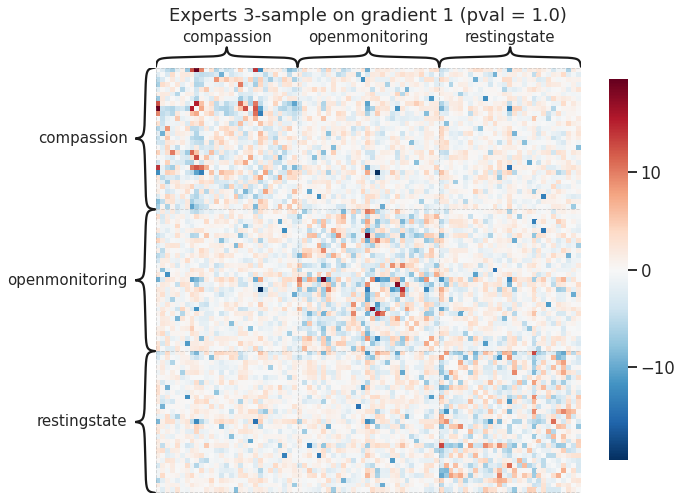

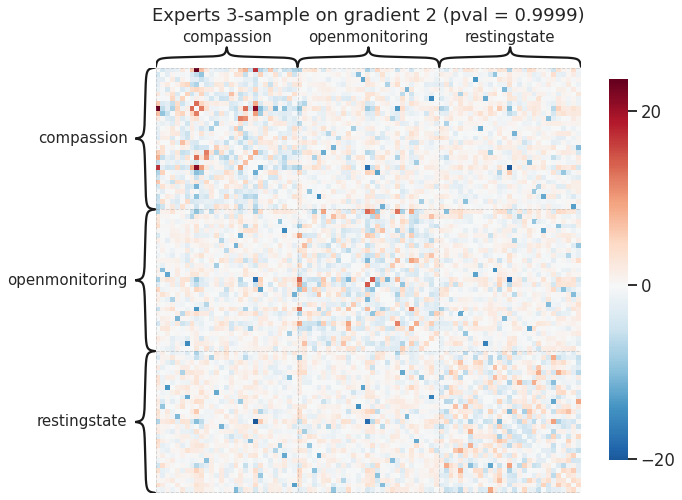

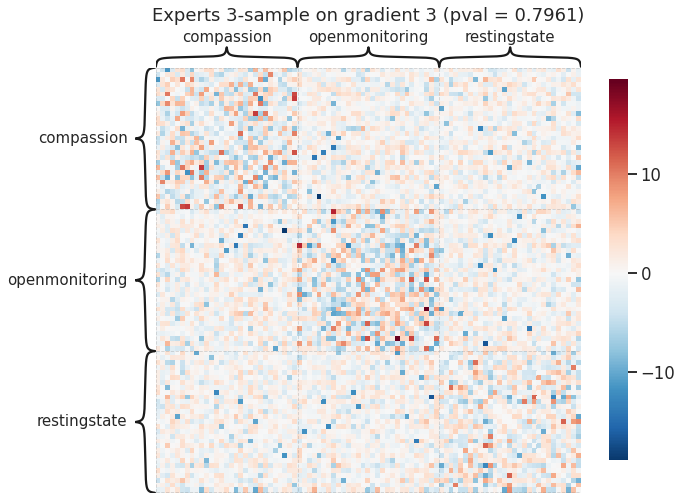

<IPython.core.display.Javascript object>

In [24]:
for i in range(X.shape[2]):
    X_dists = pairwise_distances(X[:, :, i], metric="euclidean")
    Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

    stat, pvalue, c_mat = Dcorr(compute_distance=None).test(
        X_dists, Y_dists, workers=-1, reps=10000, c_mat=True
    )

    fig = heatmap(
        c_mat,
        title=f"Experts 3-sample on gradient {i+1} (pval = {pvalue})",
        transform=None,
        inner_hier_labels=y_labels,
        hier_label_fontsize=15,
    )
    plt.savefig(
        f"../reports/c-matrices/gradient_comparisons/dcorr-experts-3sample-grad_{i+1}.pdf"
    )

## State Comparison
for each gradient, run dcorr on 1-state vs other 2 for all all 3 different expert states

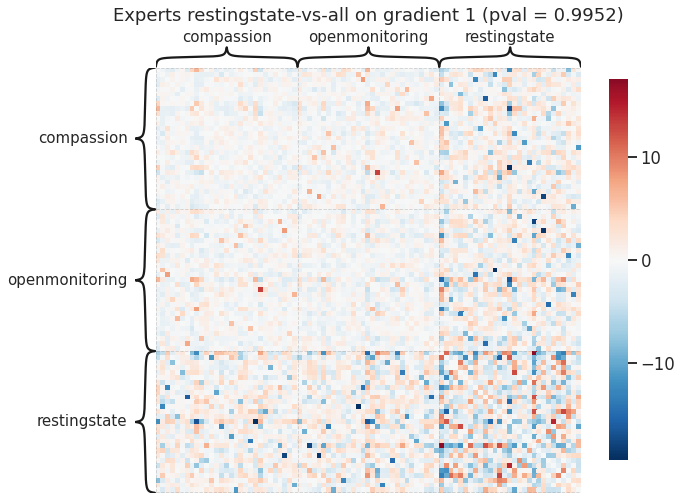

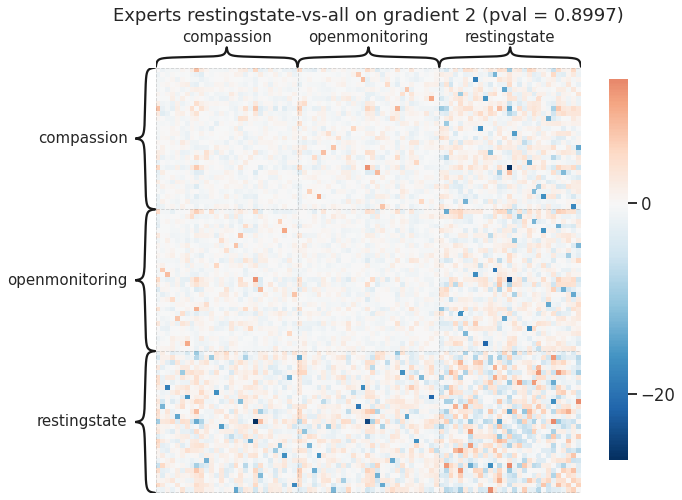

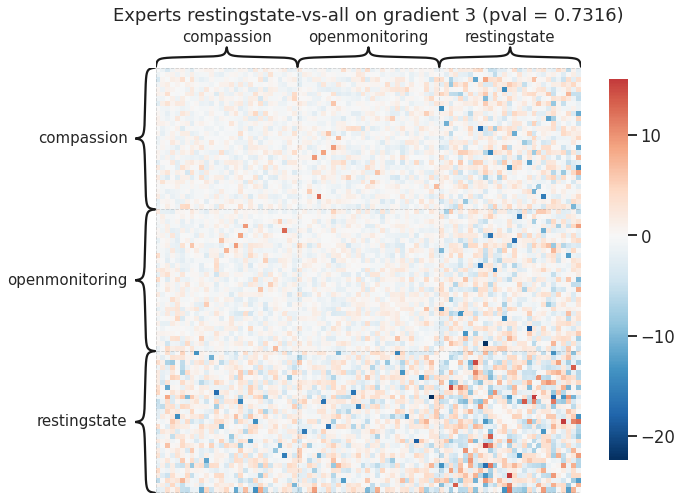

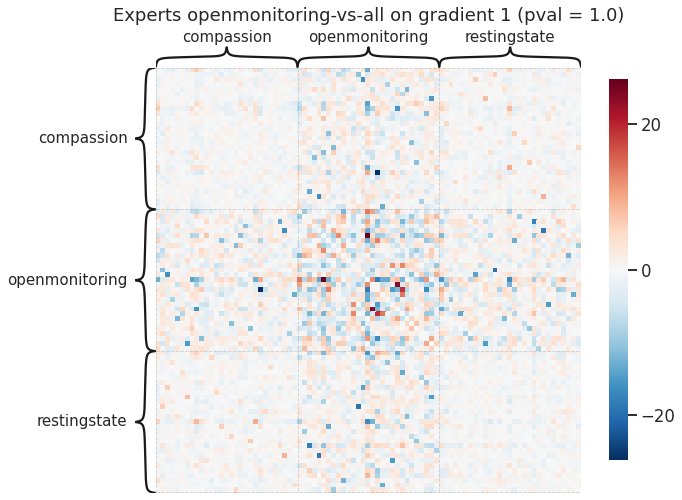

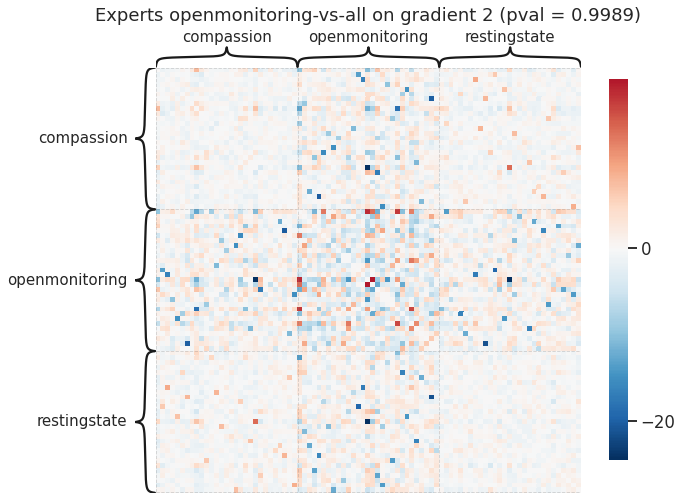

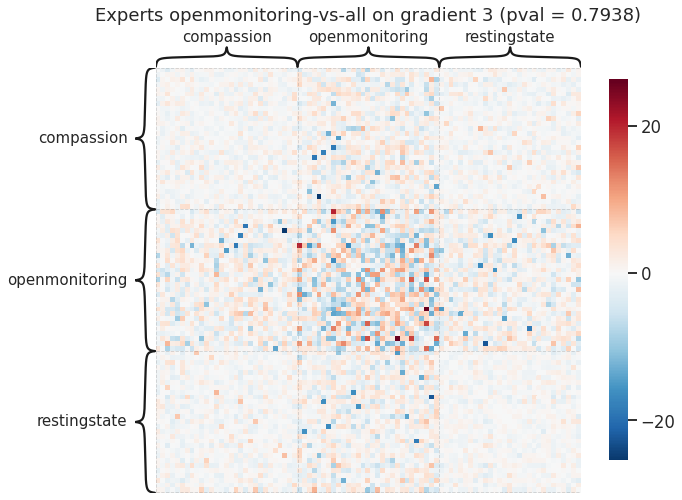

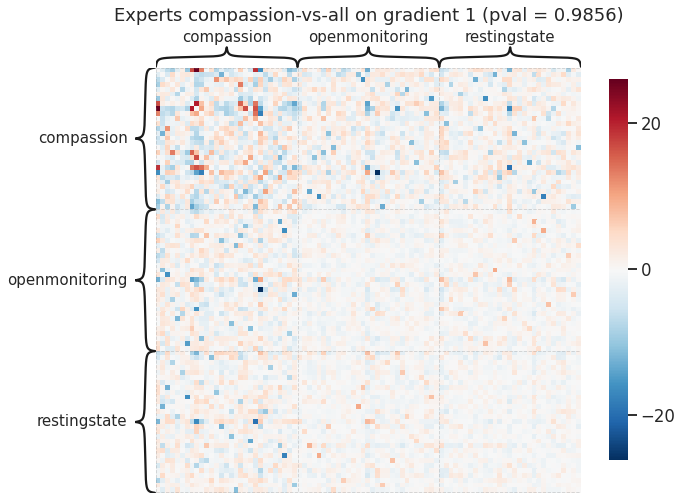

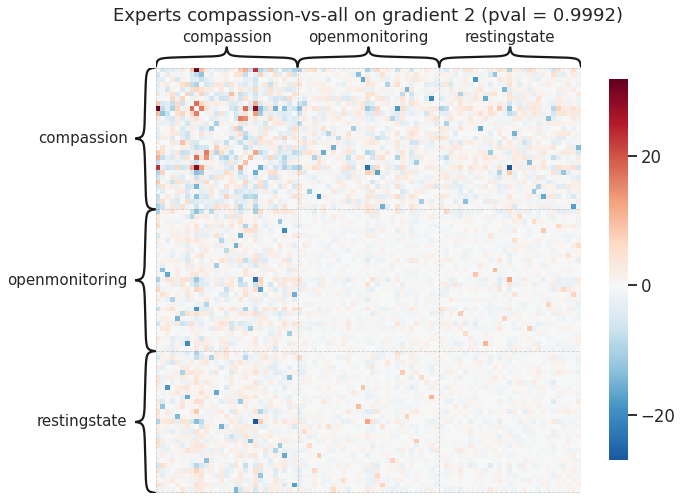

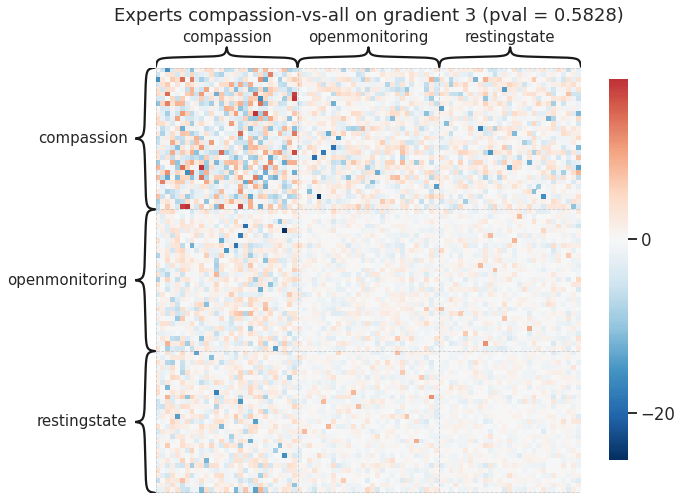

<IPython.core.display.Javascript object>

In [25]:
for state in range(3):
    ## Each state
    ways = [[0], [0], [0]]
    ways[state] = [1]
    X, Y = k_sample_transform(groups[:3], ways=ways)
    X = X[:, :, :3]
    for i in range(X.shape[2]):
        ## Each gradient
        X_dists = pairwise_distances(X[:, :, i], metric="euclidean")
        Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

        stat, pvalue, c_mat = Dcorr(compute_distance=None).test(
            X_dists, Y_dists, workers=-1, reps=10000, c_mat=True
        )

        fig = heatmap(
            c_mat,
            title=f"Experts {labels[state][1]}-vs-all on gradient {i+1} (pval = {pvalue})",
            transform=None,
            inner_hier_labels=y_labels,
            hier_label_fontsize=15,
        )
        plt.savefig(
            f"../reports/c-matrices/gradient_comparisons/dcorr-experts-{labels[state][1]}-grad_{i+1}.pdf"
        )

## Experts vs novices
for each gradient
1. compute dcorr C matrix for each state between traits
2. extract the diagonal blocks (call them Bi,j, where i indexes state and j indexes trait)
3. for each state i, compute test statistic t_i = sum(sum(Bi,j)) - sum(sum(Bi,j')). do a permutation test.

In [26]:
from hyppo.independence.dcorr import _center_distmat

<IPython.core.display.Javascript object>

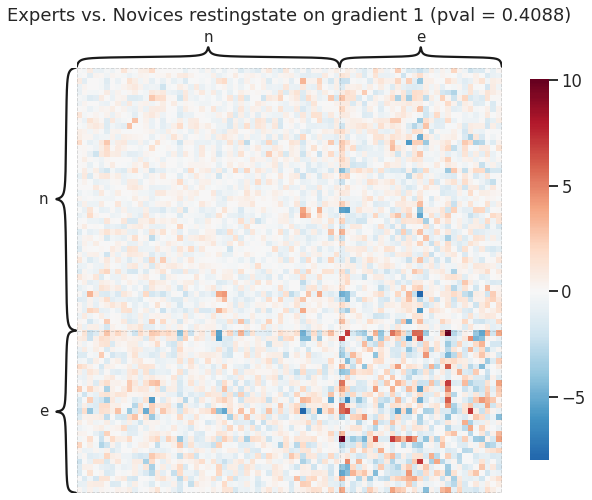

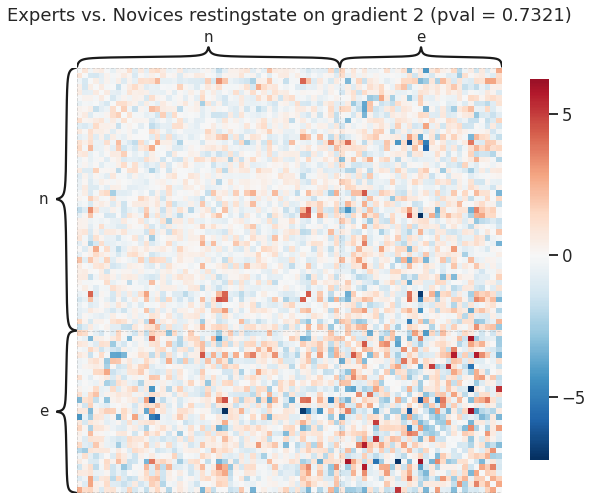

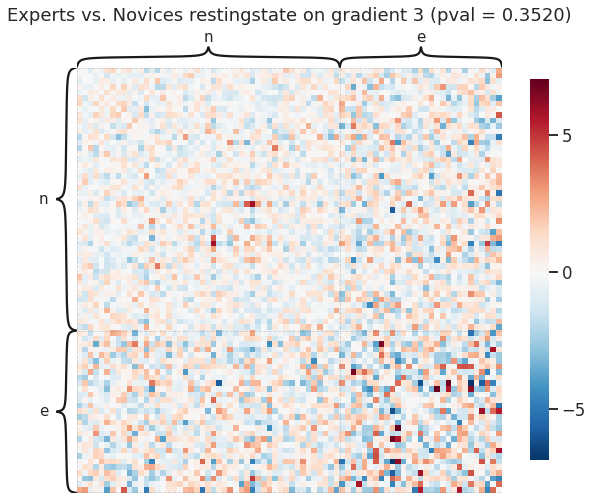

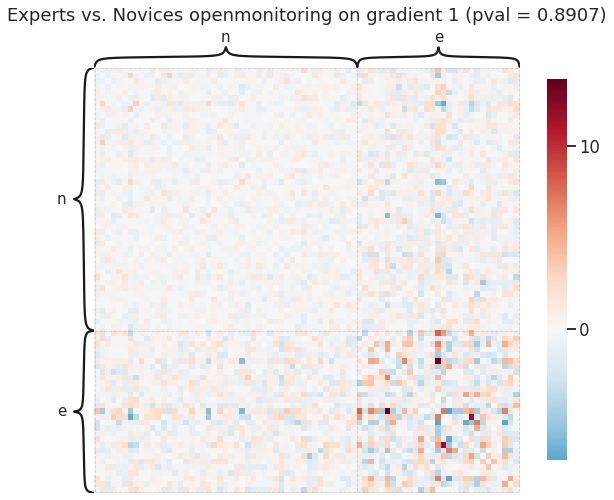

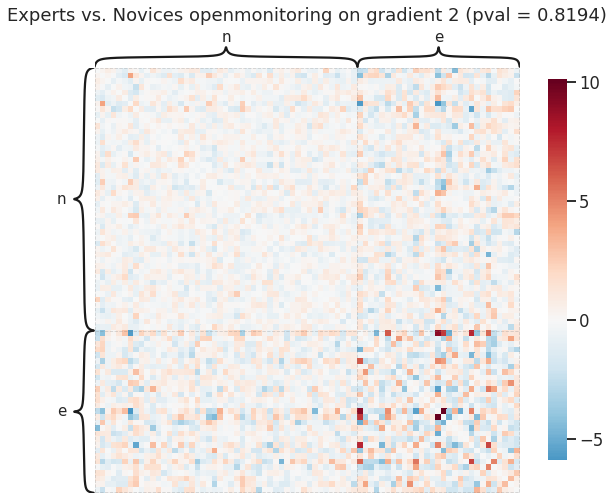

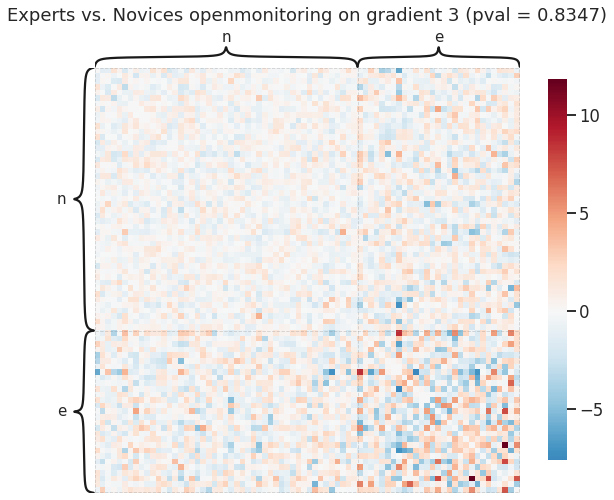

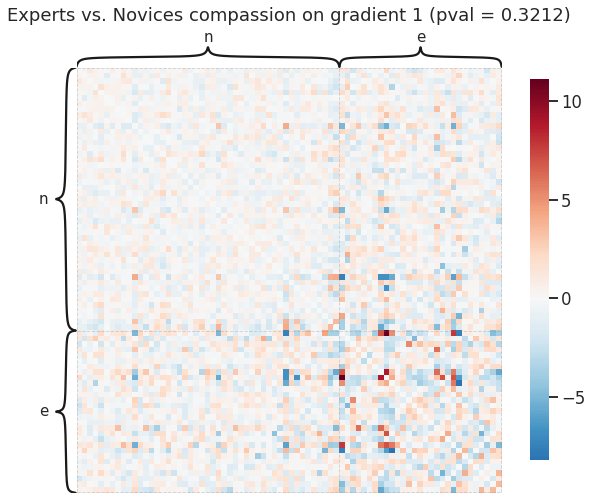

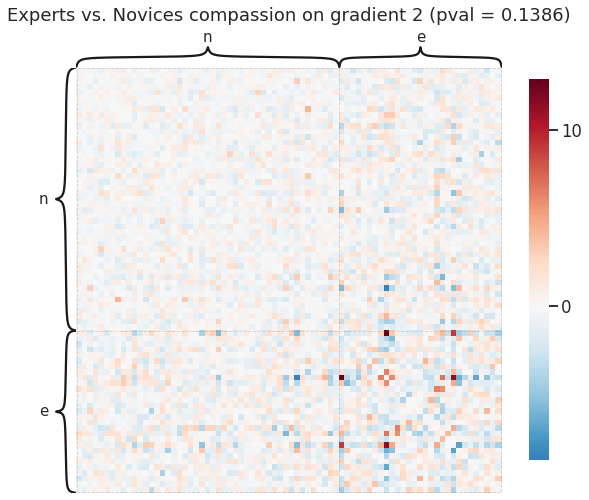

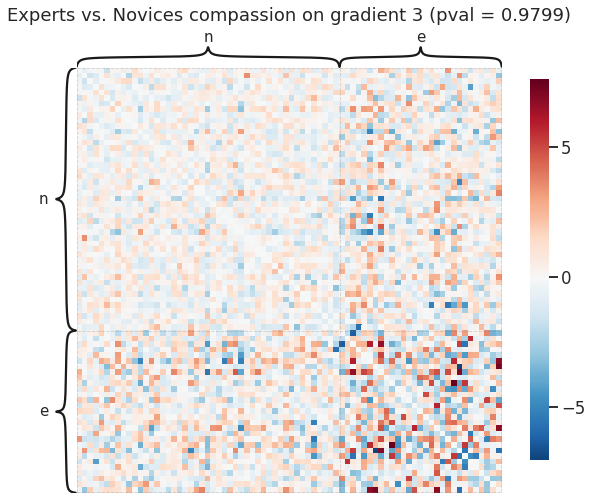

<IPython.core.display.Javascript object>

In [27]:
n_permutations = 10000

for state in range(3):
    ## Each state
    ways = [[0], [1]]
    X, Y = k_sample_transform(
        (np.asarray(groups[state]), np.asarray(groups[state + 3])), ways=ways
    )
    X = X[:, :, :3]

    y = np.repeat(
        [labels[i] for i in [state, state + 3]],
        [len(groups[i]) for i in [state, state + 3]],
        axis=0,
    )
    y_labels = [f"{a}" for a, b in y]

    for i in range(X.shape[2]):
        ## Each gradient
        X_dists = pairwise_distances(X[:, :, i], metric="euclidean")
        Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

        ##C matrix
        X_centered_dists = _center_distmat(X_dists, bias=False)
        Y_centered_dists = _center_distmat(Y_dists, bias=False)
        c_mat = X_centered_dists * Y_centered_dists

        ## Observed test statistics
        expert_idx = np.where(Y[:, 0] == 1)[0]
        novice_idx = np.where(Y[:, 0] == 0)[0]
        test_stat = np.sum(c_mat[np.ix_(expert_idx, expert_idx)]) - np.sum(
            c_mat[np.ix_(novice_idx, novice_idx)]
        )

        ## Permute to form null and estimate p value
        pvalue = 1
        Y_null = Y.copy()
        for _ in range(n_permutations):
            ## Shuffle the Y labels for the null
            np.random.shuffle(Y_null)
            ## Make estimate the null sample Y distance and c mat
            Y_dists = pairwise_distances(Y_null, metric="sqeuclidean") / 2
            Y_centered_dists = _center_distmat(Y_dists, bias=False)
            null_c_mat = X_centered_dists * Y_centered_dists
            ## Calculate the difference in distance in the null c mat
            expert_idx = np.where(Y_null[:, 0] == 1)[0]
            novice_idx = np.where(Y_null[:, 0] == 0)[0]
            null_stat = np.sum(null_c_mat[np.ix_(expert_idx, expert_idx)]) - np.sum(
                null_c_mat[np.ix_(novice_idx, novice_idx)]
            )
            ## Evaluate if it was >= the observed and normalize
            pvalue += int(null_stat >= test_stat)
        pvalue /= n_permutations + 1

        ## Plot
        fig = heatmap(
            c_mat,
            title=f"Experts vs. Novices {labels[state][1]} on gradient {i+1} (pval = {pvalue:.4f})",
            transform=None,
            inner_hier_labels=y_labels,
            hier_label_fontsize=15,
        )
        plt.savefig(
            f"../reports/c-matrices/gradient_comparisons/dcorr-e_vs_n-{labels[state][1]}-grad_{i+1}.pdf"
        )

## Experts vs novices
for each gradient
1. compute dcorr C matrix
2. extract the diagonal blocks (call them Bi,j, where i indexes state and j indexes trait)
3. for each state i, compute test statistic t_i = sum(sum(Bi,j)) - sum(sum(Bi,j')). do a permutation test.

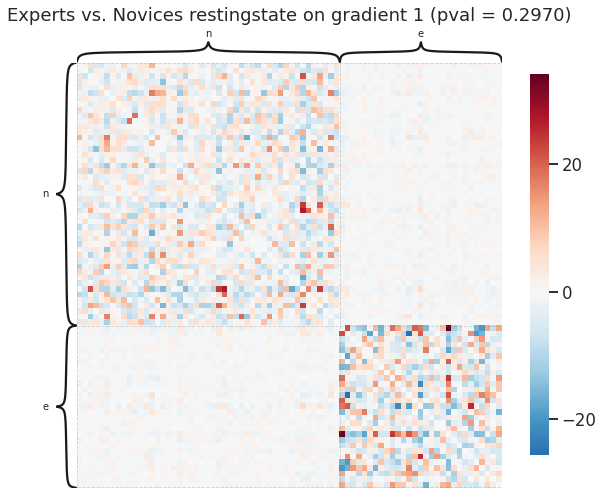

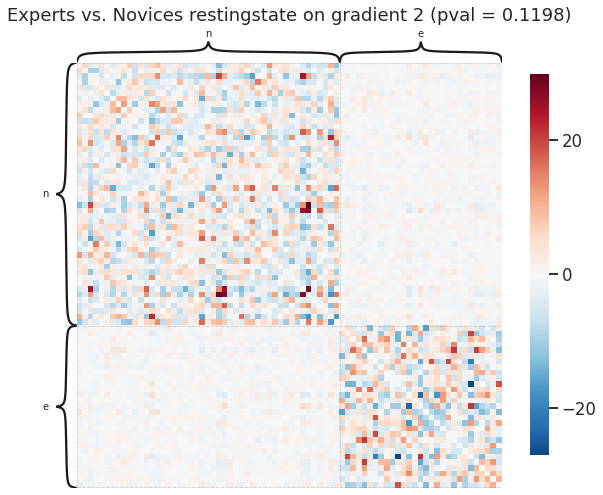

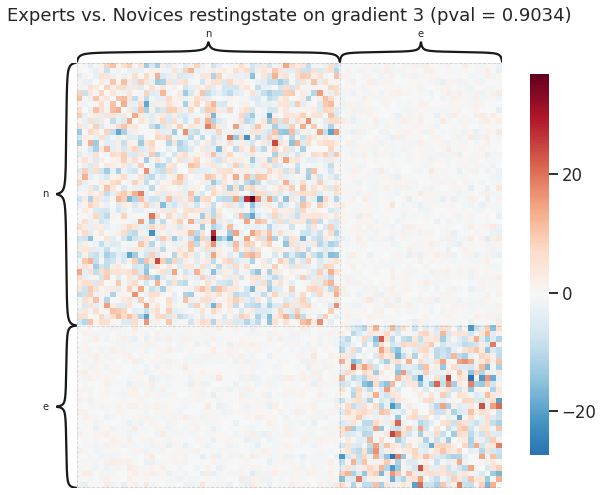

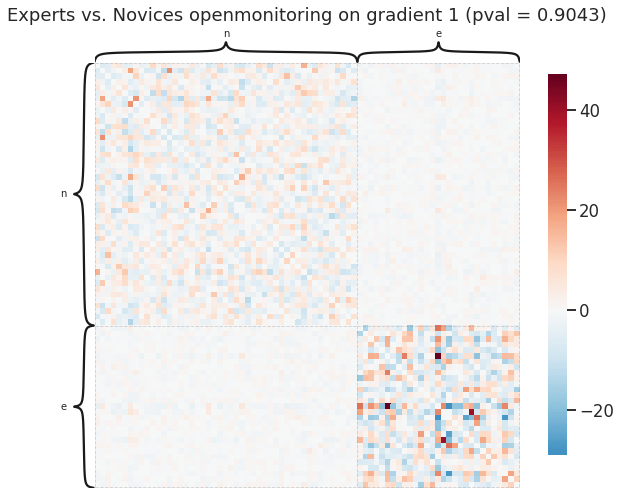

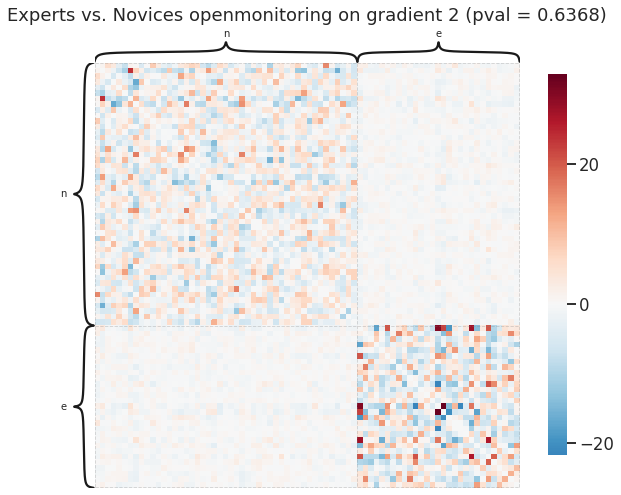

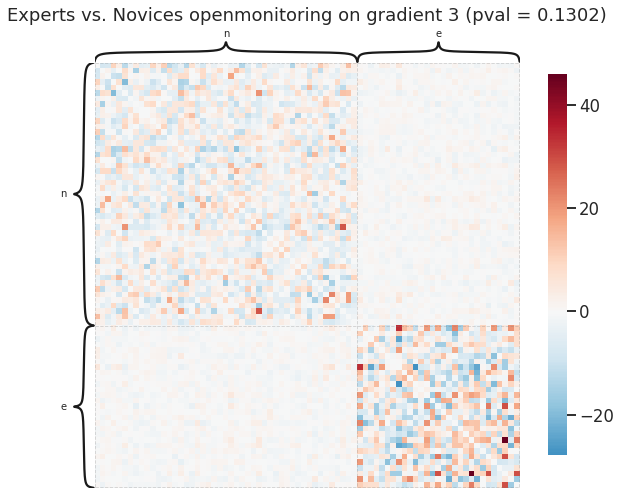

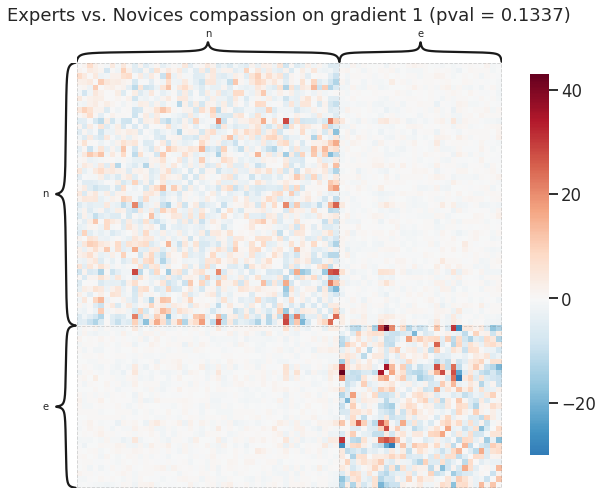

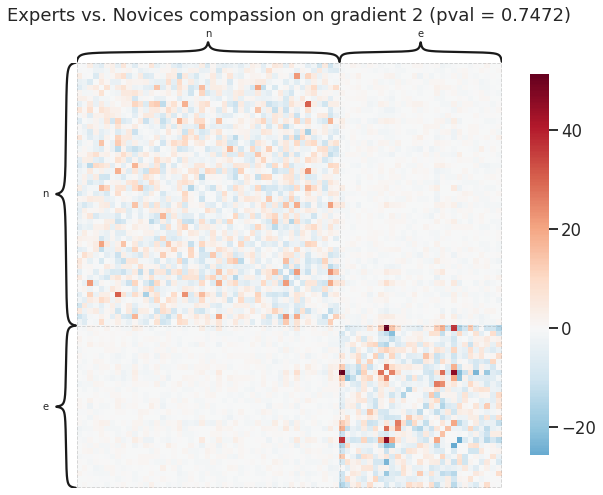

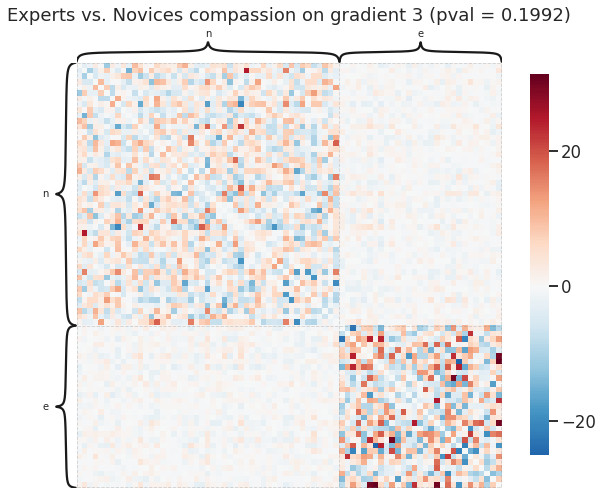

<IPython.core.display.Javascript object>

In [10]:
n_permutations = 10000

ways = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]
X, Y = k_sample_transform(groups, ways=ways)
X = X[:, :, :3]

for state in range(3):
    ## Each state
    y = np.repeat(
        [labels[i] for i in [state, state + 3]],
        [len(groups[i]) for i in [state, state + 3]],
        axis=0,
    )
    y_labels = [f"{a}" for a, b in y]
    for i in range(X.shape[2]):
        ## Each gradient
        X_dists = pairwise_distances(X[:, :, i], metric="euclidean")
        Y_dists = pairwise_distances(Y, metric="sqeuclidean") / 2

        # Rows/cols in the full matrix where the state of interest is
        state_idxs = np.where(Y[:, state + 2] == 1)[0]

        ##C matrix
        X_centered_dists = _center_distmat(X_dists, bias=False)
        Y_centered_dists = _center_distmat(Y_dists, bias=False)
        c_mat = X_centered_dists * Y_centered_dists
        c_mat = c_mat[np.ix_(state_idxs, state_idxs)]

        ## Observed test statistics
        expert_idx = np.where(Y[state_idxs, 0] == 1)[0]
        novice_idx = np.where(Y[state_idxs, 0] == 0)[0]
        test_stat = np.sum(c_mat[np.ix_(expert_idx, expert_idx)]) - np.sum(
            c_mat[np.ix_(novice_idx, novice_idx)]
        )

        ## Permute to form null and estimate p value
        pvalue = 1
        Y_null = Y.copy()
        for _ in range(n_permutations):
            ## Shuffle the Y labels for the null
            np.random.shuffle(Y_null)
            # Rows/cols in the full matrix where the state of interest is
            state_idxs = np.where(Y_null[:, state + 2] == 1)[0]
            ## Make estimate the null sample Y distance and c mat
            Y_dists = pairwise_distances(Y_null, metric="sqeuclidean") / 2
            Y_centered_dists = _center_distmat(Y_dists, bias=False)
            null_c_mat = X_centered_dists * Y_centered_dists
            null_c_mat = null_c_mat[np.ix_(state_idxs, state_idxs)]
            ## Calculate the difference in distance in the null c mat
            expert_idx = np.where(Y_null[state_idxs, 0] == 1)[0]
            novice_idx = np.where(Y_null[state_idxs, 0] == 0)[0]
            null_stat = np.sum(null_c_mat[np.ix_(expert_idx, expert_idx)]) - np.sum(
                null_c_mat[np.ix_(novice_idx, novice_idx)]
            )
            ## Evaluate if it was >= the observed and normalize
            pvalue += int(null_stat >= test_stat)
        pvalue /= n_permutations + 1

        ## Plot
        fig = heatmap(
            c_mat,
            title=f"Experts vs. Novices {labels[state][1]} on gradient {i+1} (pval = {pvalue:.4f})",
            transform=None,
            inner_hier_labels=y_labels,
            hier_label_fontsize=10,
        )
        plt.savefig(
            f"../reports/c-matrices/gradient_comparisons/dcorr-e_vs_n-{labels[state][1]}_all-grad_{i+1}.pdf"
        )

## Trait Agnostic expert vs novice

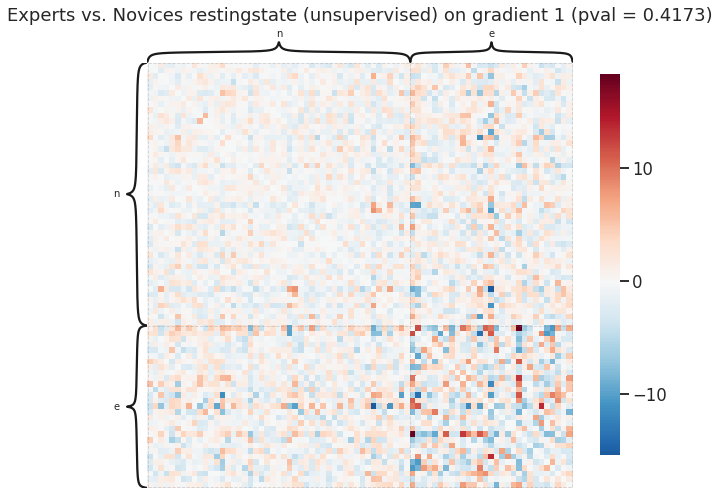

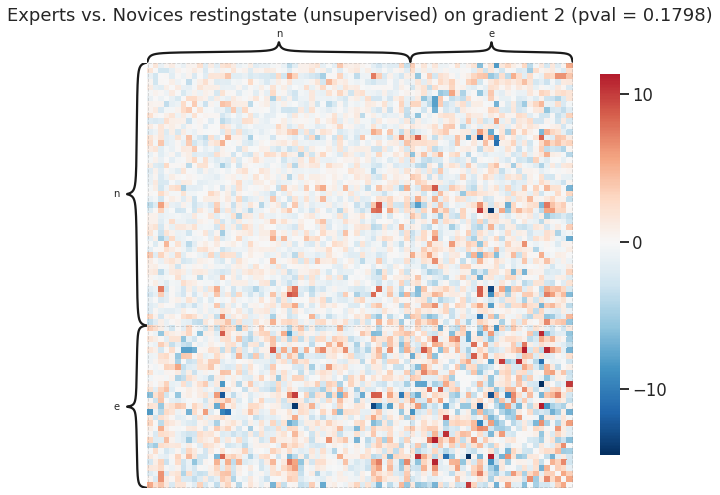

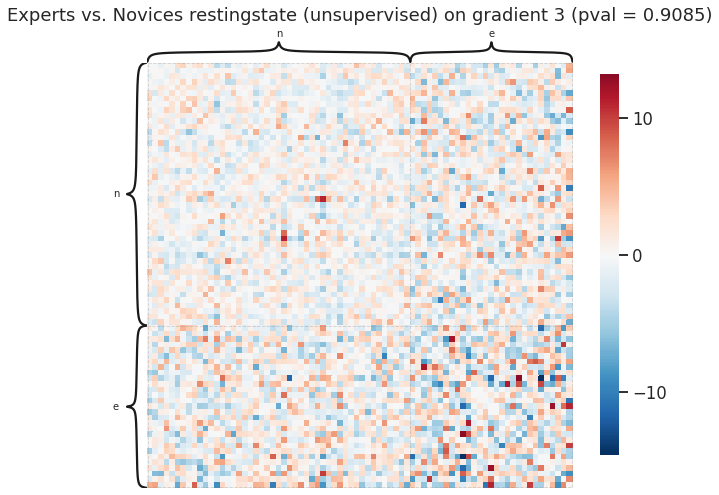

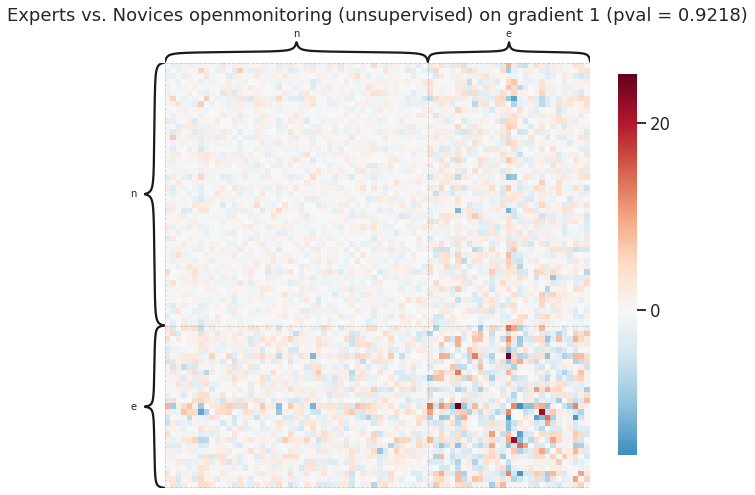

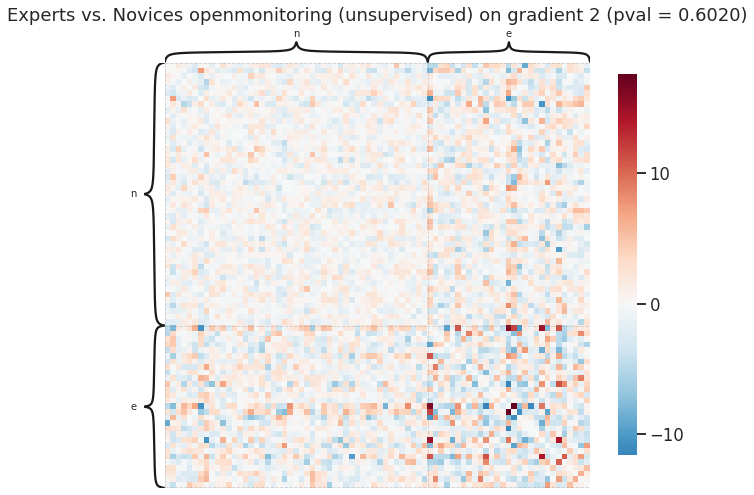

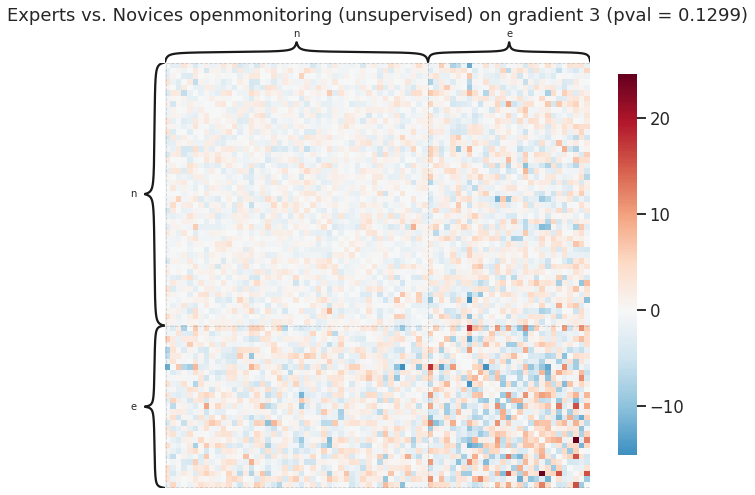

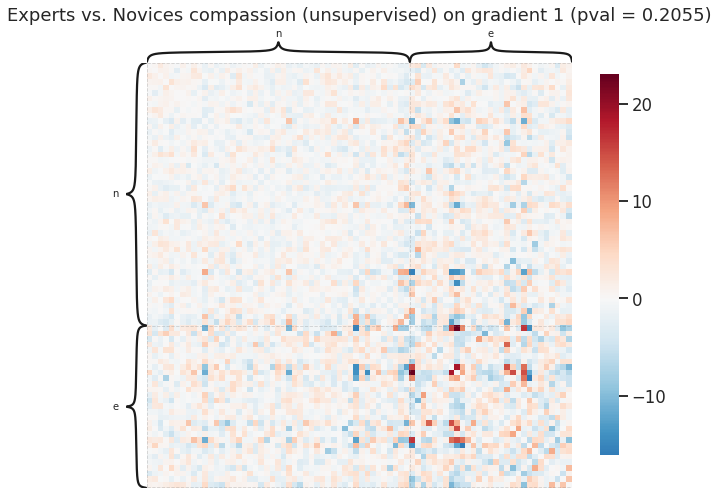

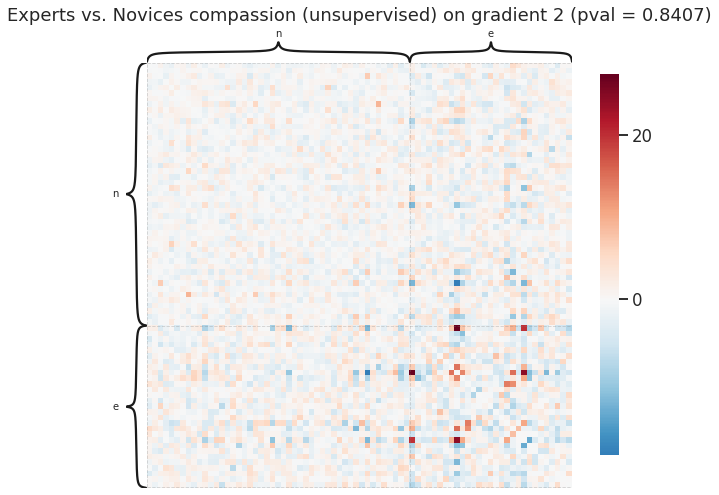

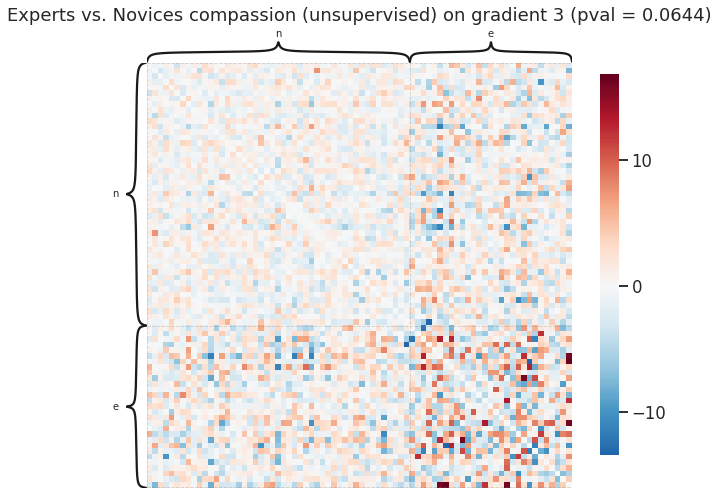

<IPython.core.display.Javascript object>

In [28]:
n_permutations = 10000

ways = [[0, 0], [0, 1], [0, 2], [1, 0], [1, 1], [1, 2]]
X, Y = k_sample_transform(groups, ways=ways)
X = X[:, :, :3]

for state in range(3):
    ## Each state
    y = np.repeat(
        [labels[i] for i in [state, state + 3]],
        [len(groups[i]) for i in [state, state + 3]],
        axis=0,
    )
    y_labels = [f"{a}" for a, b in y]
    for i in range(X.shape[2]):
        ## Each gradient
        X_dists = pairwise_distances(X[:, :, i], metric="euclidean")
        Y_dists = pairwise_distances(Y[:, :2], metric="sqeuclidean") / 2

        # Rows/cols in the full matrix where the state of interest is
        state_idxs = np.where(Y[:, state + 2] == 1)[0]

        ##C matrix
        X_centered_dists = _center_distmat(X_dists, bias=False)
        Y_centered_dists = _center_distmat(Y_dists, bias=False)
        c_mat = X_centered_dists * Y_centered_dists
        c_mat = c_mat[np.ix_(state_idxs, state_idxs)]

        ## Observed test statistics
        expert_idx = np.where(Y[state_idxs, 0] == 1)[0]
        novice_idx = np.where(Y[state_idxs, 1] == 1)[0]
        test_stat = np.sum(c_mat[np.ix_(expert_idx, expert_idx)]) - np.sum(
            c_mat[np.ix_(novice_idx, novice_idx)]
        )

        ## Permute to form null and estimate p value
        pvalue = 1
        Y_null = Y.copy()
        for _ in range(n_permutations):
            ## Shuffle the Y labels for the null
            np.random.shuffle(Y_null)
            # Rows/cols in the full matrix where the state of interest is
            state_idxs = np.where(Y_null[:, state + 2] == 1)[0]
            ## Make estimate the null sample Y distance and c mat
            Y_dists = pairwise_distances(Y_null[:, :2], metric="sqeuclidean") / 2
            Y_centered_dists = _center_distmat(Y_dists, bias=False)
            null_c_mat = X_centered_dists * Y_centered_dists
            null_c_mat = null_c_mat[np.ix_(state_idxs, state_idxs)]
            ## Calculate the difference in distance in the null c mat
            expert_idx = np.where(Y_null[state_idxs, 0] == 1)[0]
            novice_idx = np.where(Y_null[state_idxs, 1] == 1)[0]
            null_stat = np.sum(null_c_mat[np.ix_(expert_idx, expert_idx)]) - np.sum(
                null_c_mat[np.ix_(novice_idx, novice_idx)]
            )
            ## Evaluate if it was >= the observed and normalize
            pvalue += int(null_stat >= test_stat)
        pvalue /= n_permutations + 1

        ## Plot
        fig = heatmap(
            c_mat,
            title=f"Experts vs. Novices {labels[state][1]} (unsupervised) on gradient {i+1} (pval = {pvalue:.4f})",
            transform=None,
            inner_hier_labels=y_labels,
            hier_label_fontsize=10,
        )
        plt.savefig(
            f"../reports/c-matrices/gradient_comparisons/dcorr-e_vs_n-{labels[state][1]}_unsupervised-grad_{i+1}.pdf"
        )